In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from tqdm import tqdm
from torch.utils.data import DataLoader

from utils.lstm import LSTMRegressor
from utils.weather_dataset import WeatherDataset
from utils.graphics import draw_series

data_folder = '../resource/dataset'

# Load data and model

In [5]:
metadata = pd.read_csv(f'{data_folder}/metadata.csv')
metadata = metadata[metadata['attributes'] != 'weather_description']
city_coords = pd.read_csv(f'{data_folder}/raw/city_attributes.csv')

dfs = {
    attribute: pd.read_csv(f'{data_folder}/preprocessed/{attribute}.csv', index_col=0)
    for attribute in metadata['attributes']
}

city_coords = (city_coords
    .set_index('City')
    .loc[dfs['humidity']
    .columns][['Latitude', 'Longitude']]
)

dataset = WeatherDataset(7, city_coords, *dfs.values())

In [6]:
checkpoint = torch.load('../resource/models/lstm_mlp/4layer_2mlp_cp1.tar', 'cpu', weights_only=False)

model = LSTMRegressor(
    dataset[0][0].shape[1], len(dfs),
    num_layers=4
)
print(model.load_state_dict(checkpoint['model']))
model.eval();

<All keys matched successfully>


# Get predictions

In [9]:
pbar = tqdm(DataLoader(dataset, 32, False))

predictions = []
with torch.no_grad():
    for sequence, _ in pbar:
        predictions.append(model(sequence))

predictions = torch.concat(predictions)

100%|██████████| 2114/2114 [01:11<00:00, 29.38it/s]


# Visualizations

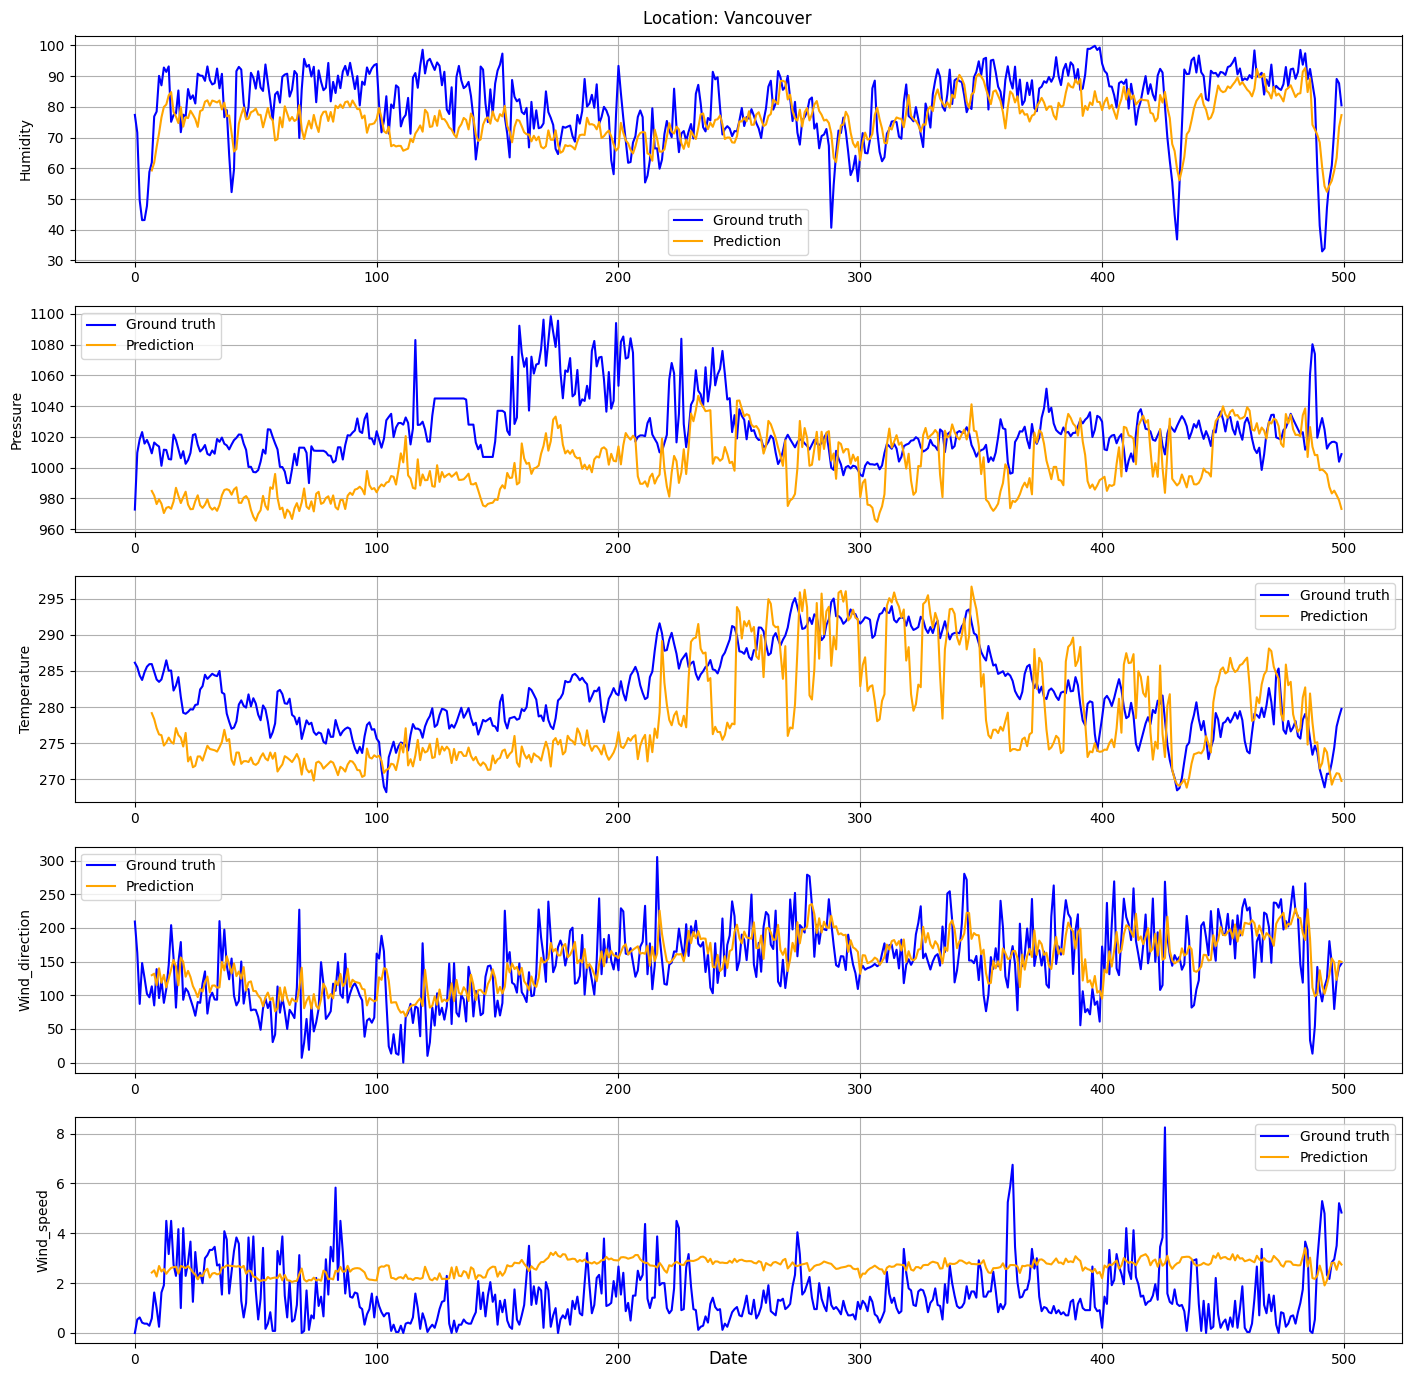

In [54]:
feature_idx, city_idx = 3, 0
no_day, lag_dur = 500, 7


fig = plt.figure(figsize=(14, 14))
axes = fig.subplots(len(dfs), 1)

fig.suptitle(f'Location: {dfs['humidity'].columns[city_idx].capitalize()}')
fig.tight_layout()
for feature_idx, ax in enumerate(axes):
    feature = list(dfs.keys())[feature_idx]
    values = dfs[feature][dfs[feature].columns[city_idx]]

    start_idx = city_idx * dataset._total_sequences

    draw_series(
        values[:no_day].values,
        predictions[start_idx : (start_idx + no_day - lag_dur), feature_idx],
        lag_dur, ax=ax, ylabel=feature
    )
    ax.grid()
fig.supxlabel('Date');